In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models

# !pip install captum

from captum.attr import IntegratedGradients, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

     |████████████████████████████████| 1.3 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 5.4 MB/s  eta 0:00:01
You should consider upgrading via the '/zhome/2b/8/212341/multiview-seg-dtu/.venv/bin/python3 -m pip install --upgrade pip' command.


In [3]:
class SimpleSegmentationModel(nn.Module):
    def __init__(self):
        super(SimpleSegmentationModel, self).__init__()
        
        # Downsampling (Encoder)
        self.conv1 = nn.Conv2d(11, 32, kernel_size=3, padding=1)  # Input channels: 11
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Upsampling (Decoder)
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2)  # Output channels: 1 for binary mask
        
    def forward(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # Downsample by factor of 2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # Downsample by factor of 2
        
        # Decoder
        x = F.relu(self.upconv1(x))
        x = torch.sigmoid(self.upconv2(x))  # Sigmoid to keep output in range [0, 1]
        
        return x

In [6]:
# loading the pretrained model
model = torch.load('cnn_model.pth')

# Set the model to evaluation mode
model.eval()

/tmp/ipykernel_3151315/3896553930.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('cnn_model.pth')


SimpleSegmentationModel(
  (conv1): Conv2d(11, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv1): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (upconv2): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
)

In [7]:
image_dir = '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well2_200locations'
mask_dir = '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/masks'

sample_number = 11

# Validate the sample number (1-200)
if not (1 <= sample_number <= 200):
    raise ValueError("Sample number must be between 1 and 200.")

# Format the sample number as a three-digit string (e.g., 8 becomes '008')
sample_str = f"s{str(sample_number).zfill(3)}"

image_filenames = [f"Alexa488_Fibroblasts_well2_200locations_{sample_str}z{str(i).zfill(2)}c2_ORG.tif" for i in range(1, 12)]
mask_filename = f"Alexa488_Fibroblasts_well2_200locations_{sample_str}z06c1_ORG_mask.tiff"
print(image_filenames)

['Alexa488_Fibroblasts_well2_200locations_s011z01c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z02c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z03c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z04c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z05c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z06c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z07c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z08c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z09c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z10c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z11c2_ORG.tif']


In [9]:
image_filenames = [f"Alexa488_Fibroblasts_well2_200locations_{sample_str}z{str(i).zfill(2)}c2_ORG.tif" for i in range(1, 12)]

# Filter for files in the directory that match the image filenames
image_files = [f for f in os.listdir(image_dir) if f in image_filenames]

images = []

for idx, image_file in enumerate(image_files):
        img_path = os.path.join(image_dir, image_file)
        img = Image.open(img_path).convert("L")  # Convert to grayscale if needed
        images.append(img)

In [10]:
print(len(images))

11


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [20]:
# Transformation pipeline for each image
transform = transforms.Compose([
    transforms.Resize(256),          # Resize to 256x256
    transforms.CenterCrop(224),      # Crop to 224x224
    transforms.ToTensor(),           # Convert to Tensor (1, 224, 224 for grayscale)
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for grayscale
])

# Assuming `images` is a list of 11 grayscale
transformed_images = []

for i in images:  # Apply transformations to each image
    transformed_img = transform(i)  # Shape: [1, 224, 224]
    transformed_images.append(transformed_img)

# Stack images along the channel dimension
input_tensor = torch.stack(transformed_images, dim=0)  # Shape: [11, 1, 224, 224]

# Permute dimensions to create input of shape [1, 11, 224, 224] (batch_size=1)
input_tensor = input_tensor.permute(1, 0, 2, 3).to(device) 

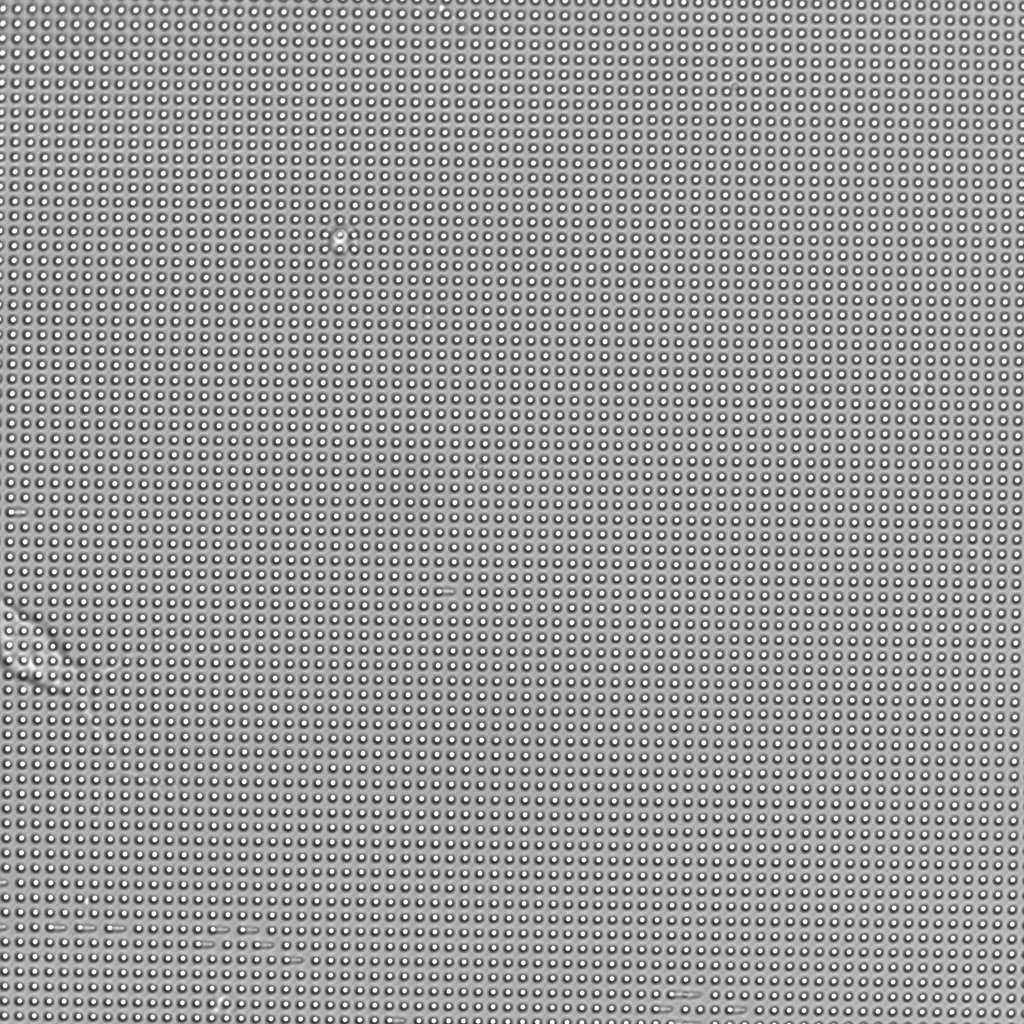

In [12]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# standard for grey scale
transform_normalize = transforms.Normalize(
    mean=[0.5],
    std=[0.5]
 )

img = images[0]

display(img)

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

In [21]:
# img_input = img.to(device)

with torch.no_grad():  # No gradient computation needed for inference
    output = model(input_tensor)  # Forward pass

print(output)

tensor([[[[0.2785, 0.2681, 0.2799,  ..., 0.2286, 0.2349, 0.2330],
          [0.2782, 0.2734, 0.2799,  ..., 0.2275, 0.2338, 0.2310],
          [0.2691, 0.2912, 0.2704,  ..., 0.2373, 0.2288, 0.2296],
          ...,
          [0.2315, 0.2275, 0.2338,  ..., 0.2346, 0.2318, 0.2218],
          [0.2260, 0.2236, 0.2292,  ..., 0.2302, 0.2281, 0.2259],
          [0.2275, 0.2189, 0.2292,  ..., 0.2327, 0.2347, 0.2247]]]],
       device='cuda:0')


In [24]:
print(output.shape)

torch.Size([1, 1, 224, 224])


In [29]:
# Initialize IntegratedGradients
ig = IntegratedGradients(model)

# Target can be the output index you want to compute the saliency map for
# For segmentation, we may choose a specific pixel (e.g., pixel at (64, 64))
target_pixel = (0, 64, 64)  # Example target: (batch_index, height, width)

def segmentation_target(output):
    # Return only the specific pixel's value as the target for attribution
    return output[0, 0, target_pixel[1], target_pixel[2]]

In [30]:
baseline = torch.zeros_like(input_tensor)  # Baseline (all zeros for simplicity)

# Pass the input and baseline through the model
attributions = ig.attribute(
    input_tensor, baseline, 
    n_steps=50, 
    additional_forward_args=None,
    target=None
)

# Extract the scalar value for the target pixel (forward pass + custom selection)
output = model(input_tensor)
target_value = segmentation_target(output)

# Perform backpropagation for attributions w.r.t target_value
target_value.backward()

AssertionError: Target not provided when necessary, cannot take gradient with respect to multiple outputs.

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             methods=["original_image", "heat_map"],
                             cmap=default_cmap,
                             show_colorbar=True,
                             signs=["all", "positive"],
                             outlier_perc=1)